<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/12-architectures/TL_AE_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [ ]:
np.random.seed(1337)

# Dog Breed Identification




Download the dataset from [Dog Breed Identification
 Competition](https://www.kaggle.com/competitions/dog-breed-identification/data)

In [ ]:
!pip install -q kaggle
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ivanzakharov","key":"29c644c1db898a9fd1988fc7533f1971"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dog-breed-identification

100% 690M/691M [00:19<00:00, 42.2MB/s]
100% 691M/691M [00:19<00:00, 37.5MB/s]


In [ ]:
!unzip dog-breed-identification.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: data/train/83fad0718581a696132c96c166472627.jpg  
  inflating: data/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: data/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: data/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: data/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: data/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: data/train/840dbad5a691c22611d85b2488

Let's use 64 most frequent breeds to simplify the task.

In [ ]:
INPUT_SIZE = 224
NUM_CLASSES = 64
data_dir = '/content/data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [ ]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(4838, 65) (1210, 65)


<ipython-input-8-0037ea12ab23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['target'] = 1
<ipython-input-8-0037ea12ab23>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['rank'] = labels.groupby('breed').rank()['id']


Custom dataset is going to be useful for our needs.

In [ ]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir + 'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir + 'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)


In [ ]:
len(train_dl)

1210

In [ ]:
#img, label = next(iter(train_dl))
print(next(iter(train_dl))[1])


tensor([46, 34, 22, 55])


In [ ]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 224, 224]) torch.Size([4])


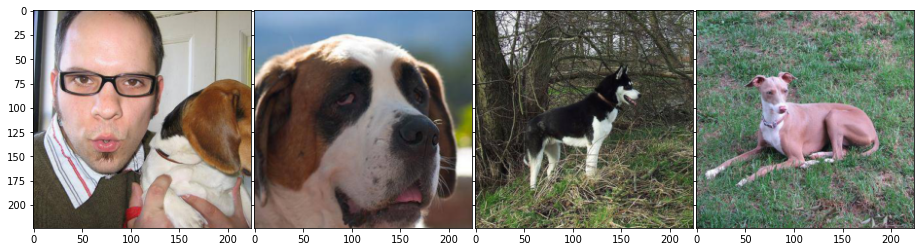

In [ ]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

# Task 1: Transfer Learning (2 points)



Pick up some pretrained model, e.g. resnet 50 and tune it for our needs.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
resnet = resnet.to(device)
inputs, labels = inputs.to(device), labels.to(device)
outputs = resnet(inputs)
outputs.size()

torch.Size([4, 1000])

This models provides us with 1000 values, representing the classes which ResNet was trained on. 

Replace last layer with one that predicts the 64 classes. 
The network weights should be fixed expected for the last layer that is trained.

In [ ]:
labels

tensor([39, 52, 14,  1], device='cuda:0')

In [ ]:
import torch.nn.functional as F

In [ ]:
def train_model(dataloders,
                model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1):
    # Train the model and evaluate train and test accuracy
    # YOUR CODE
    
    loss_res = 0    
    for epoch in range(num_epochs):
        for idx, batch in enumerate(dataloders.get('train')):
            xs, ys_true = batch
            
            logits_pred = model(xs.to(device))
            
            loss = criterion(logits_pred, ys_true.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()

            _, outputs = torch.max(logits_pred.data, 1)
            accuracy_score = (outputs.cpu() == ys_true).sum() / outputs.shape[0]

            if idx % 100 == 0:
              print(accuracy_score.item())
              print(loss.item())                
            loss_res += loss.item()

    return loss_res / len(dataloders.get('train'))

In [ ]:
def train_model_one_batch(dataloders,
                model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1):
    # Train the model and evaluate train and test accuracy
    # YOUR CODE

    batch = next(iter(dataloders.get('train')))
    
    loss_res = 0    
    for epoch in range(num_epochs):
        #for batch in dataloders.get('train'):
        xs, ys_true = batch
            
        logits_pred = model(xs.to(device))
            
        loss = criterion(logits_pred, ys_true.to(device))
            
        optimizer.zero_grad()
        loss.backward()
        print(loss.item())
        optimizer.step()
        #scheduler.step()                
        loss_res += loss.item()

    return loss_res / len(dataloders)

In [ ]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# add new layer
# hint: you can get the number of features
# using in_features, e.g resnet.fc.in_features

resnet.fc = torch.nn.Linear(resnet.fc.in_features, 64)

resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [ ]:
train_error = train_model(dloaders, resnet, criterion, optimizer, scheduler, num_epochs=1)

0.5
1.5839834213256836
0.75
1.4445464611053467
0.5
1.2957074642181396
0.75
1.0324668884277344
0.75
1.261297345161438
0.75
1.585536241531372
0.75
1.0174798965454102
0.75
1.1555771827697754
0.75
0.9257144927978516
0.5
1.0068085193634033
0.5
1.2560747861862183
1.0
0.37464219331741333
0.75
0.8553723692893982


In [ ]:
print(train_error)

1.253971687316402


In [ ]:
def test_epoch(net, loader, criterion, device): 
    net.eval()
    loss_res = 0
    for batch in loader.get('valid'):
            xs, ys_true = batch
            
           
            with torch.no_grad():
                logits_pred = net(xs.to(device))
                loss = criterion(logits_pred, ys_true.to(device))
                            
                loss_res += loss.item()

    return loss_res / len(loader)

In [ ]:
val_error = test_epoch(resnet, dloaders, criterion, device)
print(val_error)

641.11922955513


In [ ]:
def train(net, train_loader, test_loader, optimizer, epochs, criterion, device): 
    train_losses = np.zeros((epochs))
    test_losses = np.zeros((epochs))
    for epoch in range(epochs):
        train_losses[epoch] = train_model(train_loader, net, criterion, optimizer, scheduler)
        test_losses[epoch] = test_epoch(net, test_loader, criterion, device)
        print("Epoch %d/%d: Train loss = %.4f - Test loss = %.4f" 
              % (epoch + 1, epochs, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses

In [ ]:
epochs = 10
train(resnet, dloaders, dloaders, optimizer, epochs, criterion, device)

Epoch 1/10: Train loss = 2563.0700 - Test loss = 641.0906
Epoch 2/10: Train loss = 2563.0138 - Test loss = 640.9934


KeyboardInterrupt: ignored

In [ ]:
from tqdm.auto import tqdm

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(dloaders['valid']):
        inputs, labels = data
        outputs = resnet(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy on test: ',
    100 * correct / total)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/303 [00:00<?, ?it/s]

Accuracy on test:  68.18181818181819


In [ ]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, ' Prediction: {}\n Real Label: {}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

In [ ]:
# data = dloaders['valid']
# for i, (inputs, labels) in enumerate(data):
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, preds = torch.max(outputs.data, 1)
#         print(preds)

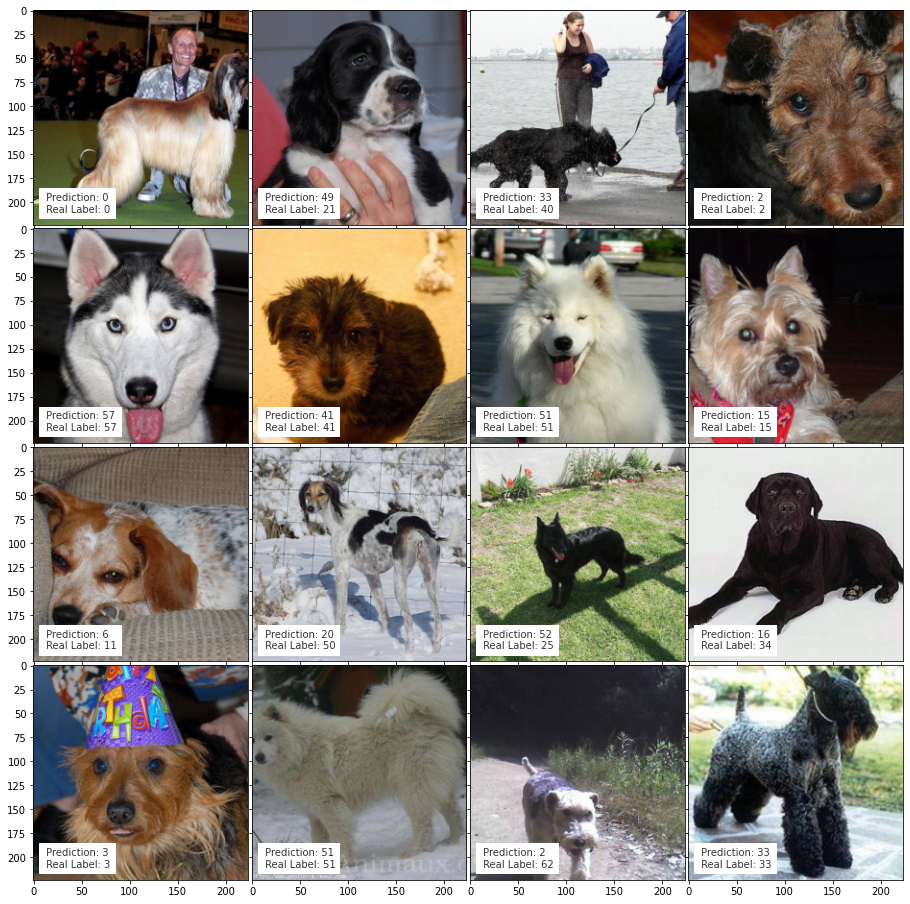

In [ ]:
visualize_model(dloaders, resnet)

# Task 2: Low-dimensional dogs (4 points)
Train a **Conditional CNN Autoencoder** that takes class labels into account. Show examples of interpolations between instances of different classes in a latent space and related representation of images in original space (just the same way we did it during practical session). 

In [ ]:
dim_hidden = 64

In [ ]:

for index, labels in enumerate(train_dl):
    
    new_labels = nn.functional.one_hot(labels[1], num_classes = 64)
    labels[1] = new_labels
    print(labels)
    break
    


#print(next(iter(train_dl)))
#for index, labels in enumerate(train_dl):
#    print (labels)
    
    

In [ ]:
encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 1, 3, stride=2, padding=1),
            nn.ReLU(True)
        )

In [ ]:
enc = Encoder(64)
dec = Decoder(64, 64)

In [ ]:
batch = next(iter(train_dl))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
batch[0].shape

torch.Size([4, 3, 224, 224])

In [ ]:
encoded = enc(batch[0])

In [ ]:
encoded.shape

torch.Size([4, 64])

In [ ]:
oh_label = F.one_hot(batch[1])

In [ ]:
oh_label.shape

torch.Size([4, 26])

In [ ]:
x = torch.cat([encoded, oh_label], dim=1)

In [ ]:
x.shape

torch.Size([4, 90])

In [ ]:
dec(x)

RuntimeError: ignored

In [ ]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 1, 3, stride=2, padding=1),
            nn.ReLU(True)
        )

        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(1*28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = x.view(-1, 28*28) 
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim+fc2_input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 1*28*28),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(1, 28, 28))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(1, 16, 3, stride=2,
                               padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2,
                               padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 48

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=64)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=112, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for idx, (image_batch, label) in enumerate(dataloader): # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        
        # Make one-hot from label
        oh_label = F.one_hot(label, num_classes=64)
        oh_label = oh_label.to(device)

        # Encode data
        encoded_data = encoder(image_batch)

        # Concat latent encoder dim with one-hot label
        decoder_batch = torch.cat([encoded_data, oh_label], dim=1)

        # Decode data
        decoded_data = decoder(decoder_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if idx % 100 == 0:
          print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Make one-hot from label
            oh_label = F.one_hot(label, num_classes=64)
            oh_label = oh_label.to(device)
            # Encode data
            encoded_data = encoder(image_batch)

            # Concat latent encoder dim with one-hot label
            decoder_batch = torch.cat([encoded_data, oh_label], dim=1)

            # Decode data
            decoded_data = decoder(decoder_batch)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
num_epochs = 3
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device, train_dl,loss_fn,optimizer)
   val_loss = test_epoch(encoder,decoder,device,valid_dl,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)

	 partial train loss (single batch): 1.267741
	 partial train loss (single batch): 1.529257
	 partial train loss (single batch): 0.901589
	 partial train loss (single batch): 1.630274
	 partial train loss (single batch): 1.477245
	 partial train loss (single batch): 1.249628
	 partial train loss (single batch): 0.909620
	 partial train loss (single batch): 1.521268
	 partial train loss (single batch): 1.175869
	 partial train loss (single batch): 1.024740
	 partial train loss (single batch): 1.133777
	 partial train loss (single batch): 0.797000
	 partial train loss (single batch): 1.592032

 EPOCH 1/3 	 train loss 1.3187795877456665 	 val loss 1.2576885223388672
	 partial train loss (single batch): 1.763420
	 partial train loss (single batch): 1.082663
	 partial train loss (single batch): 1.549934
	 partial train loss (single batch): 1.276576
	 partial train loss (single batch): 1.267560
	 partial train loss (single batch): 1.158561
	 partial train loss (single batch): 1.117660
	 part

Latent space interpolation part

In [ ]:
with torch.no_grad():
  image_batch, label = next(iter(train_dl))
  image_batch = image_batch.to(device)
  # Make one-hot from label
  oh_label = F.one_hot(label, num_classes=64)
  oh_label = oh_label.to(device)
  # Encode data
  encoded_data = encoder(image_batch)

  # Concat latent encoder dim with one-hot label
  decoder_batch = torch.cat([encoded_data, oh_label], dim=1)

  # Decode data
  decoded_data = decoder(decoder_batch)

In [ ]:
decoded_data, image_batch

(tensor([[[[1.3084e-02, 6.5086e-03, 8.0292e-03,  ..., 7.4090e-03,
            7.4793e-03, 2.8068e-02],
           [2.5795e-03, 1.4475e-03, 2.4785e-04,  ..., 1.5562e-03,
            5.5100e-04, 7.8971e-03],
           [3.1383e-03, 4.7708e-04, 1.5057e-04,  ..., 4.8405e-04,
            9.6468e-05, 8.2668e-03],
           ...,
           [6.1856e-03, 1.6433e-03, 1.8110e-04,  ..., 2.7718e-02,
            1.6551e-02, 5.7452e-02],
           [7.2410e-03, 1.1335e-03, 2.4532e-04,  ..., 2.8751e-02,
            1.4986e-02, 8.3359e-02],
           [4.4968e-02, 1.5103e-02, 8.6807e-03,  ..., 1.1462e-01,
            9.8551e-02, 1.5523e-01]],
 
          [[1.3130e-02, 4.7424e-03, 9.2685e-03,  ..., 6.0668e-03,
            7.6890e-03, 5.1741e-02],
           [3.4689e-03, 2.4644e-03, 1.0187e-03,  ..., 2.2843e-03,
            1.2606e-03, 1.6189e-02],
           [3.4354e-03, 4.3926e-04, 1.2258e-04,  ..., 3.2393e-04,
            5.8130e-05, 4.6267e-03],
           ...,
           [7.0093e-03, 1.8490e-03, 7.

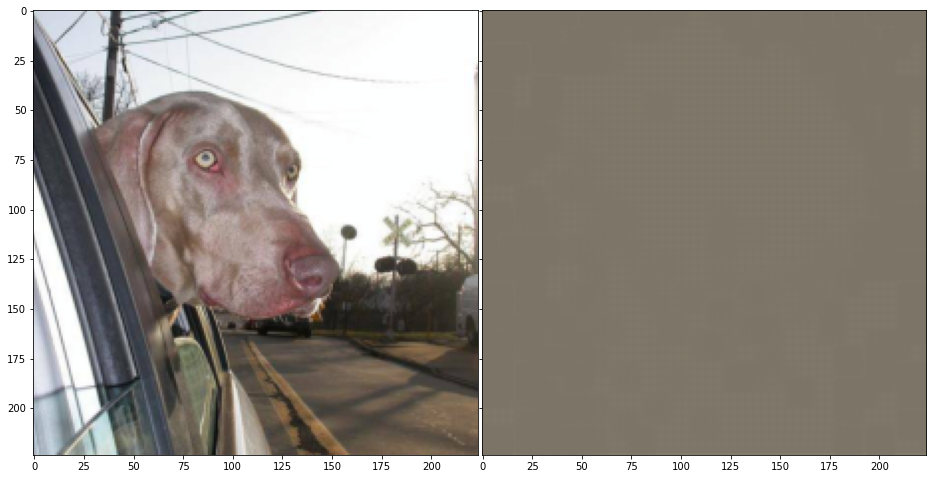

In [ ]:
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)

imshow(grid[0], image_batch[0].cpu())
imshow(grid[1], decoded_data[0].cpu())

In [ ]:
imshow(axis=0, inp=image_batch.cpu())

ValueError: ignored

# Task 3: Boosting the quality (2 points)

The general objective here is to boost the quality you got on the first step. 
You can tune one/two more models from `torchvision` or `timm` and stack their predictions **OR** create your own CNN and use the encoder of your Autoencoder from 2nd task **OR** both. 

Don't forget to compare your models properly, e.g. it's not enough to run them for only a few epochs.

Write a comment on model comparison, things and ideas that helped boost the quality, and anything else you would like to share. 